# Выявление профилей потребления


## Цели и задачи проекта


Заказчик: Интернет-магазин товаров для дома.

Данные описывают транзакции интернет-магазина товаров для дома и быта.

Цель исследования: выявление точек роста продаж за счет предоставления пользователям персонализированных предложений

Задачи:

1. Предобработка данных:
    - выявление явных и скрытых дубликатов
    - проверка пропусков
    - проверка корректности типов данных
    - добавление расчетных столбцов (дата, время, сумма покупки)
    

2. Исследовательский анализ данных
    - проверка описательной статистики
    - проверка распределений данных, визуализация распределений
    - анализ аномалий и выбросов
    - классификация товаров по группам
    
    
3. Сегментация клиентов на основе RFM-анализа:
    - На основе имеющихся данных определить границы присвоения оценок от 1 до 3 по каждому из признаков — recency (давность покупки), frequency (частота покупок) и monetary (сумма трат клиента)
    - Каждому клиенту нужно присвоить оценку от 1 до 3 по каждому из признаков
    - Распределение клиентов по группам (Отток, Активные клиенты, Пассивные клиенты)
    
    
4. Формирование гипотез о поведении различных групп пользователей
5. Проверка гипотез
6. Рекомендации по каждой из групп пользователей
7. Итоговые выводы по работе

 ## Материалы:
 * [Презентация] https://disk.yandex.ru/i/M-wNatDPcnCE8Q

## Предобработка данных

Установим и импортируем необходимые библиотеки

In [82]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import warnings
warnings.simplefilter('ignore')
from scipy import stats as st


___

Откроем датасет и проверим его содержимое

In [83]:
# загружаем датасет
df = pd.read_csv('*****')
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


**Описание полей датасета:**

date — дата заказа;

customer_id — идентификатор покупателя;

order_id — идентификатор заказа;

product — наименование товара;

quantity — количество товара в заказе;

price — цена товара.

In [84]:
# выведем общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Датасет содержит 7474 строк. Пропусков нет

### проверка дубликатов

Проверка явных дубликатов

In [85]:
# проверим явные дубликаты
len(df[df.duplicated()])

0

___


Проверка неявных дубликатов

In [86]:
# проверяем неявные дубликаты в разрезе полей 'customer_id', 'order_id', 'product' без учета даты покупки
len_dup = len(df[df[['customer_id', 'order_id', 'product']].duplicated(keep='last')])
#сохраним исходный размер датафрейма
len_df = len(df)
# расчитаем долю задублированных строк по отношению к размеру датасета
perc_dup = len_dup/len_df
print (f'Обраружено {len_dup} строк с дубликатами. Доля дубликатов в датасете - {round(perc_dup*100, 2)}%')

Обраружено 1886 строк с дубликатами. Доля дубликатов в датасете - 25.23%


Предположим, что корректно первое упоминание покупки в датасете. При удалении дубликатов оставим только наиболее рание записи

In [87]:
# отсортируем данные по дате совершения покупки
df = df.sort_values(by = 'date', ascending = True)

In [88]:
# удалим дубликаты, оставив первое вхождение
df = df.drop_duplicates(subset=['customer_id','order_id', 'product'], keep = 'first')

In [89]:
# проверяем неявные дубликаты без учета даты покупки
len_dup = len(df[df[['customer_id', 'order_id', 'product']].duplicated(keep='last')])
# расчитаем долю задублированных строк по отношению к размеру датасета
perc_dup = len_dup/len_df
print (f'Обраружено {len_dup} строк с дубликатами. Доля дубликатов в датасете - {round(perc_dup*100, 2)}%')

Обраружено 0 строк с дубликатами. Доля дубликатов в датасете - 0.0%


___

Проверим наличие различных customer_id в разрезе одного order_id

In [90]:
cusromer_dubl = df.pivot_table(index = 'order_id', values = 'customer_id', aggfunc = 'nunique').sort_values(by = 'customer_id', ascending = False).reset_index()
cusromer_dubl = cusromer_dubl[cusromer_dubl['customer_id'] > 1]
cusromer_dubl.head()

,order_id,customer_id
0,72845,4
1,71480,3
2,69485,3
3,69410,2
4,71226,2


Проверим один случайный номер заказа

In [91]:
df [df ['order_id'] == 72845].head(8)

,date,customer_id,order_id,product,quantity,price
6504,2019100314,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6505,2019100315,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6508,2019100408,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6538,2019100720,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


Строки являются полными дублями

In [92]:
# проверяем количество задублированных строк
len_customer_dubl = len(df [df ['order_id'].isin(cusromer_dubl['order_id'])])

# расчитаем долю заказов с различной принадлежностью к клиентам
perc_customer_dubl = len_customer_dubl/len_df


print (f'Обраружено {len_customer_dubl} строк с аномалией. Доля аномальных данных в датасете - {round(perc_customer_dubl*100, 2)}%')

Обраружено 66 строк с аномалией. Доля аномальных данных в датасете - 0.88%


Удалим даннные строки из датафрейма, т.к. нет возможности точно идентифицировать пользователя, которому они пренадлежат. Количество дублей не очень велико, что позволяет пренебречь ими.

In [93]:
df = df [(~(df ['order_id'].isin(cusromer_dubl['order_id'])))]

# проверяем количество задублированных строк
len_customer_dubl = len(df [df ['order_id'].isin(cusromer_dubl['order_id'])])

# расчитаем долю заказов с различной принадлежностью к клиентам
perc_customer_dubl = len_customer_dubl/len_df


print (f'Обраружено {len_customer_dubl} строк с аномалией. Доля аномальных данных в датасете - {round(perc_customer_dubl*100, 2)}%')

Обраружено 0 строк с аномалией. Доля аномальных данных в датасете - 0.0%


In [94]:
print (f'По итогу обработки дубликатов в датасете осталось {len(df)} строк, что составляет {round((len(df)/len_df)*100, 2)}% исходного датасета')

По итогу обработки дубликатов в датасете осталось 5522 строк, что составляет 73.88% исходного датасета


### обработка типов данных

Обработаем тип данных для столбца 'date' - переведем в формат даты Остальные столбцы содержат данные с соответствующим типом.

In [95]:
#Изменяем тип данных
df['date'] = pd.to_datetime(df['date'], format= '%Y%m%d%H')

### добавление расчетных столбцов

Добавим поля с отдельным отображением месяца, даты и времени заказа для удобства

In [96]:
# добавим поля с отдельным отображением даты и времени для удобства
# добавляем вспомогательный столбец
df['datetime'] = df['date'].copy()
# разделяем вывод даты и времени в разных полях
df['year_month'] = df['datetime'].dt.to_period('M')
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date

# удаляем вспомогательный столбец
df = df.drop(['datetime'], axis=1)

In [97]:
#проверим итог добавления
df.head()

,date,customer_id,order_id,product,quantity,price,year_month,time
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,00:00:00
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,00:00:00
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,00:00:00
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,00:00:00
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,00:00:00


___

Добавим столбец со стоимостью покупки товара в чеке

In [98]:
#расчитываем и проверяем результат расчета
df['purchase'] = df ['quantity']*df['price']
df.tail()

,date,customer_id,order_id,product,quantity,price,year_month,time,purchase
7469,2020-01-30,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0,2020-01,21:00:00,76.0
7470,2020-01-30,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,2020-01,22:00:00,869.0
7471,2020-01-31,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0,2020-01,02:00:00,354.0
7472,2020-01-31,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01,12:00:00,128.0
7473,2020-01-31,2e460a26-35af-453d-a369-a036e95a40e0,103225,Вешалка для блузок 41 см красный Attribute AHM781,1,104.0,2020-01,15:00:00,104.0


### вывод по разделу

Проведена предобработка данных

Исходный датасет содержит 7474 строк. Пропусков нет. Явные дубликаты не обнаружены.

Обнаружены скрытые дубликаты в разрезе номер заказа/клиент/СКЮ. Доля дублей составляет 25.23%. Причина аномалия в данных, заказы задублированны на различные даты. В датасете оставлены данные на наиболее ранюю дату.

Также обнаружена аномалия в данных. К одному заказу подвязны несколько номеров клиентов. Т.к. принадлежность к конкретному пользователю определить невозможно, данные удалены из датасета. Доля удаленны данных от исходного датета составила 0.88%.

По итогу обработки дубликатов в датасете осталось 5522 строк, что составляет 73.88% исходного датасета.


Произведено изменение формата для столбца date - перевод в datetime. Столбец разделен на два, содержащий отдельно дату(date) и время (time).

Дополнительно в отдельном столбце purchase расчитана сумма покупки на основании столбцов price и quantity.




## Исследовательский анализ данных
    - проверка описательной статистики
    - проверка распределений данных, визуализация распределений
    - анализ аномалий и выбросов
    - классификация товаров по группам

### проверка описательной статистики

Выведем основную статистику по датасету и построим боксплот для визуализации статистики.
Дадим краткое описание статистики и проверим выбросы.

In [99]:
# выведем основную статистику
round(df[['quantity', 'price', 'purchase']].describe(), 2)

,quantity,price,purchase
count,5522.00,5522.00,5522.00
mean,2.58,531.58,831.17
std,16.51,975.26,9224.35
min,1.00,9.00,9.00
25%,1.00,90.00,120.00
50%,1.00,150.00,190.00
75%,1.00,524.00,734.00
max,1000.00,14917.00,675000.00


Выведем боксплот по количеству купленного товара, стоимости и сумме выручки

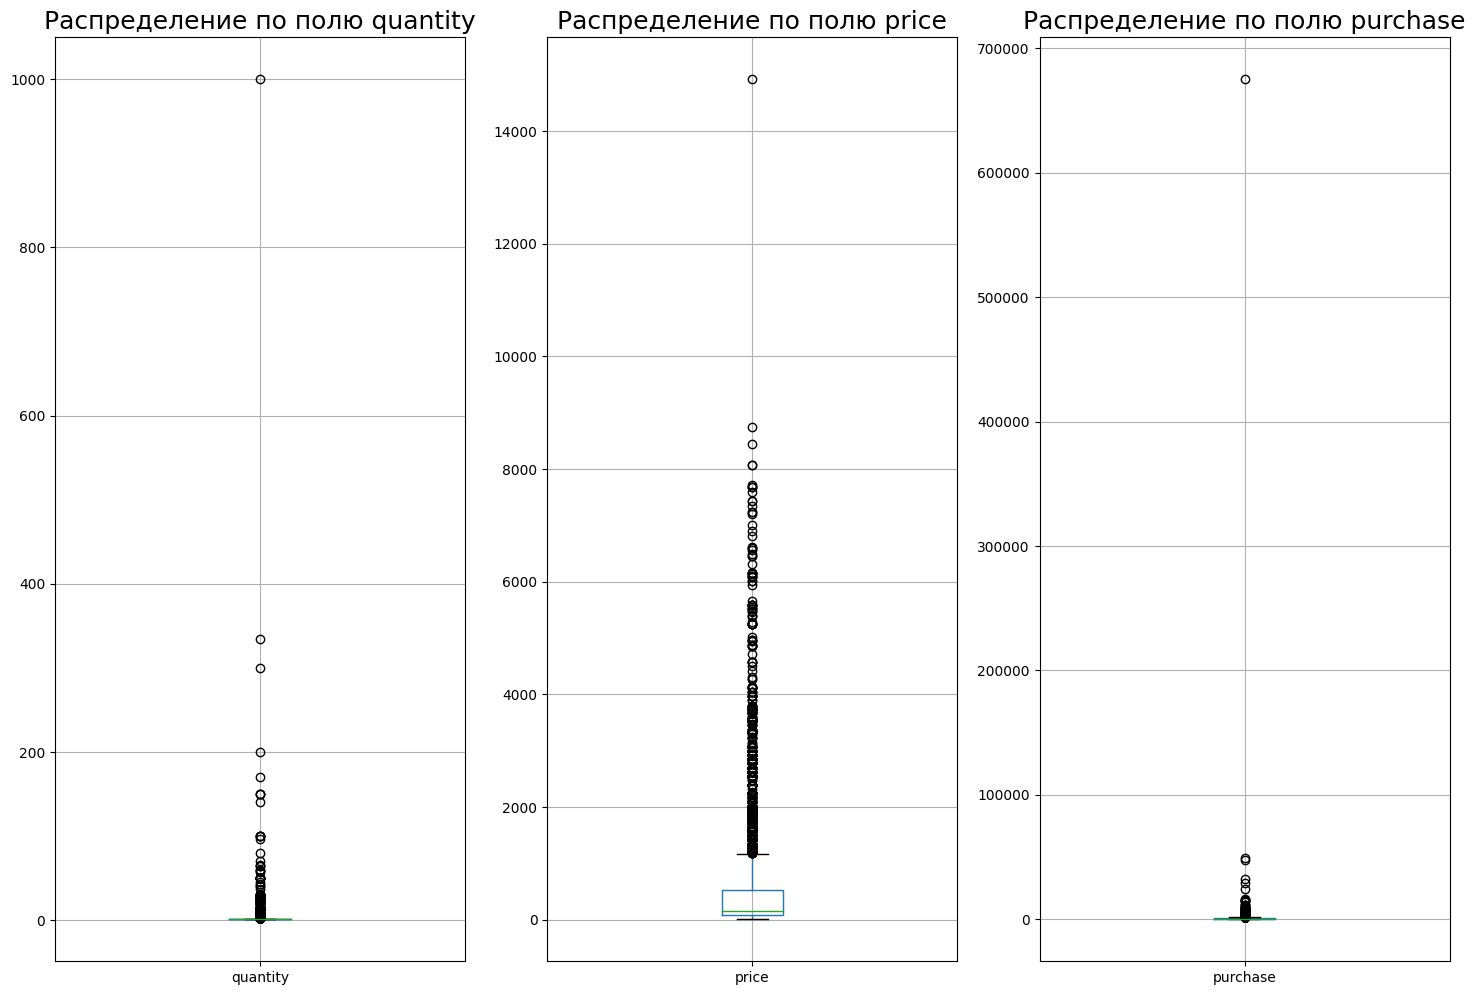

In [100]:
#Выведем боксплот в распределениями даннх величин
columns = ['quantity','price', 'purchase']
ylabels = ['Количество, шт.', 'Стоимость, у.е', 'Сумма, руб.']
# Размеры диаграмм
plt.figure(figsize=(18, 12))
for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    df[[column]].boxplot()
    plt.title(f'Распределение по полю {column}', fontsize = 18)

plt.show()

Изменим масштаб визуализации без учета 10% самых больших значений, чтобы увидеть на графике основную статистику

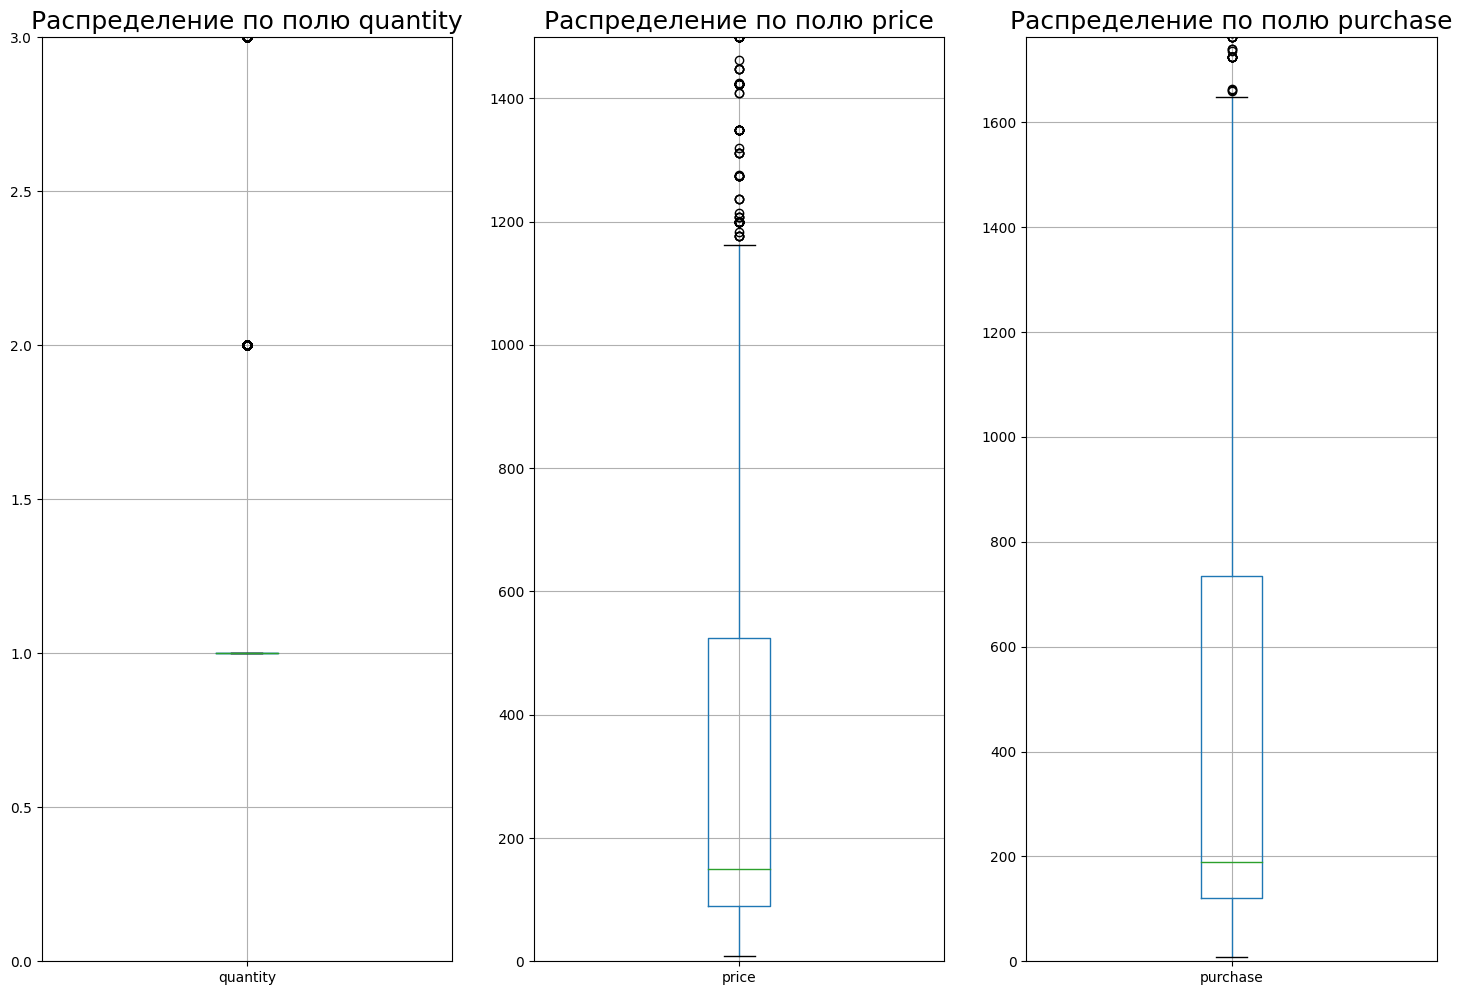

In [101]:
#Выведем боксплот в распределениями даннх величин
columns = ['quantity','price', 'purchase']
# Размеры диаграмм
plt.figure(figsize=(18, 12))
for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    ax = df[[column]].boxplot()
    ymax = np.percentile (df[column], 90)
    ymin = 0
    ax.set_ylim([ymin, ymax])

    plt.title(f'Распределение по полю {column}', fontsize = 18)

plt.show()

Для 75% записей количество заказанного тавара - 1 штука. Максимальное значение единовременного заказа 1000 шт.

Минимальная цена товара - 9 у.е, медиана - 150 у.е, среднее - 531,58 у. е. Максимальная цена товара 14917 у.е.

Минимальная сумма единовременной покупки одной СКЮ - 9 у.е, максимальная - 675 000 у.е. 75% покупок не превышает сумму 734 у.е.

Отдельно проверим выбросы по количеству заказов (свыше 130 шт) и цене СКЮ (свыше 8 тыс руб) на корректность.

**Проверим выбросы по количеству заказаннных единиц в чеке**

In [102]:
#выведем строки с выбросами по полю quantity
df[df['quantity'] > 130]

,date,customer_id,order_id,product,quantity,price,year_month,time,purchase
212,2018-10-11,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,2018-10,14:00:00,5700.0
211,2018-10-11,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2018-10,14:00:00,2850.0
568,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,2018-11,08:00:00,8670.0
586,2018-11-02,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,2018-11,11:00:00,8260.0
1158,2018-12-10,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,2018-12,14:00:00,5800.0
2431,2019-03-23,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,2019-03,10:00:00,3000.0
3961,2019-05-20,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,2019-05,21:00:00,15300.0
5071,2019-06-11,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06,07:00:00,49432.0
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06,15:00:00,675000.0


Данные выглядят правдородобно, кроме строки 5456, где в покупке числится 1000 вантузов стоимостью 675 руб.

Удалим данную строку из датасета. Остальные строки сохраним.

In [103]:
# удаляем выброс
df = df[~(df['quantity'] == 1000)]

**Проверим выбросы по стоимости СКЮ**

In [104]:
#выведем строки с выбросами по полю price
df[df['price'] > 8000]

,date,customer_id,order_id,product,quantity,price,year_month,time,purchase
1981,2019-02-24,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.0,2019-02,10:00:00,8437.0
2697,2019-04-05,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,Сумка-тележка хозяйственная Andersen Royal Sho...,1,8737.0,2019-04,19:00:00,8737.0
2997,2019-04-21,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,2019-04,16:00:00,8077.0
5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,2019-07,17:00:00,14917.0
7436,2020-01-26,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,2020-01,19:00:00,8077.0


Для данных СКЮ стоимость соответствует рыночной, поэтому сохраняем даные строки в датасете.

**Информация о количестве пользователей, заказов и СКЮ в датасете**

In [105]:
# выведем основную информацию о количестве польователей
custom_count = df['customer_id'].nunique()
order_count = df['order_id'].nunique()
sku_count = df['product'].nunique()
print (f'Количество уникальных пользователей: {custom_count}. Количество уникальных заказов: {order_count}. Количество СКЮ: {sku_count}')

Количество уникальных пользователей: 2412. Количество уникальных заказов: 3491. Количество СКЮ: 2333


Количество СКЮ слишком велико, чтобы проанализировать покупки клиентов. В разделе ниже введем группировку СКЮ покатегориям.

**Определим, за какой период имеются наблюдения**

In [106]:
print('Минимальная дата заказа', df['date'].min(), 'максимальная дата заказа', df['date'].max())

Минимальная дата заказа 2018-10-01 максимальная дата заказа 2020-01-31


**Расчитаем размер среднего чека по заказу**

In [107]:
round((df.groupby('order_id')['purchase'].sum()).describe())

count     3491.0
mean      1121.0
std       2087.0
min          9.0
25%        194.0
50%        580.0
75%       1248.0
max      49432.0
Name: purchase, dtype: float64

Средний чек по заказам составляет 1121 у.е, медианный - 580 у.е

___

### классификация товарных позиций по группам

In [108]:
# переведем данные о наименованияю СКЮ в нижний регистр, для удобства обработки
df['product'] = df['product'].str.lower()

Для того чтобы облегчить классификацию, создадим вспомогательный столбец, включающий первые два слова из наименования товара.

In [109]:
# напишем функцию по извлечению первых двух слов
def select_two_words (text):
    words = text.split()
    two_words = words [0] + ' ' + words [1]
    return (two_words)


In [110]:
# применим функцию с столбцу product
df ['product_cut'] = list(map (select_two_words, df['product']))

In [111]:
# проверим результат применения
df.head()

,date,customer_id,order_id,product,quantity,price,year_month,time,purchase,product_cut
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,00:00:00,142.0,комнатное растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,00:00:00,194.0,комнатное растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,00:00:00,112.0,радермахера d-12
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,00:00:00,179.0,хризолидокарпус лутесценс
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,00:00:00,112.0,циперус зумула


На основании полученных наименований сформируем словарь классификации СКЮ по группам. Объявим функцию классификации

In [112]:
# классифицируем различные виды товаров
# создадим словарь с соответсвием класса услуги и ключевых слов, входящик в наименование
classification_dict = {
    'растения и семена': ['салат','виноград','рассад', 'томат', 'капуст', 'арбуз', 'дыня', 'укроп', 'нивянник', 'петрушка', 'клубника', 'огурец','цинния оранжевый', 'суккулент микс', 'ель канадская','календула пинк', 'монарда гибридная', 'гайлардия крупноцветковая', 'цинния коралловая', 'кориандр в', 'лук порей', 'смолевка звездный','любисток удалец','лаватера монт','эшшольция карминный', 'бульонница luminarc', 'годеция рембранд', 'астра альпийская', 'георгина черная','солидаго желтый', 'валериана лекарственная', 'гимнокалициум микс','хоста микс', 'кориандр стимул','календула суприм', 'горох амброзия', 'рудбекия тайгер', 'дендробиум яблоневый', 'земляника барон', 'морковь детская','кодонанта укорененный','барвинок синий', 'дендробиум фиолетовый', 'лилейник высокорослый','папоротник страусник', 'тимьян овощной', 'энотера миссурийская', 'календула бронзовая','хаага','бузульник пржевальского', 'эхинацея микс', 'литопс микс', 'анемона белый', 'бадан сердцелистный', 'шалфей овощной','вигна лилиана','лобелия','зверобой продырявленный', 'эхеверия микс', 'эхинокактус грузони', 'лен небесная','змееголовник','алиссум', 'пиретрум', 'хризантема', 'калла крупноцветковая','цинерария','кипарисовик','лапчатка','тюльпан','бегония', 'бархатцы','виола рогатая', 'аквилегия обыкновенная','гиностемма укорененный', 'осина обыкновенная', 'вероника колосковая','алиссум скальный', 'ранункулус клуни', 'цинния ацтек','сельдерей листовой','гипсофила','ясколка','физостегия','камнеломка','нивянник','седум','космея','кореопсис','незабудка','гвоздика','овсянница','котовник','колокольчик','вербейник','настурция','d-1','d-2','d-9','d-7', 'фуксия', 'роза','цикламен','флокс','фиалка','антуриум','эвкалипт','бальзамин', 'примула', 'растен', 'пеларгон', 'базилик', 'мята', 'калибрахоа', 'бакопа', 'бакопа', 'вербена', 'циперус', 'петуния', 'дерев', 'в горш'],
    'декор': ['муляж', 'искуственн', 'искусствен', 'фоторамка', 'подушка'],
    'товары для дома': ['рассекатель пламени','наматрацник natures', 'отжим для', 'ткань для','мантоварка алюминиевая', 'многофункциональный инструмент', 'решетка вентиляционная','одеяло silver','лопатка c','измерительный алюминиевый','шнур хозяйственный', 'одеяло wellness', 'мыльница пластмассовая','ролик для','петля-стрела пс-286','фиксатор-шар хром', 'шило с','ванна','губка спираль','завертка форточная','ручка мебельная','шпингалет','ткань универсальная','измерительный угольник,','пододеяльник','набор ковров', 'уголок оконный', 'набор прецизионных','ерш','тряпка','наволочка','простыня','светильник настольный', 'основание для', 'сменный блок', 'скребок', 'лопатка attribute','сметка с', 'набор инструментов', 'сверло','мешок для', 'пьезозажигалка с','вкладыши для', 'шпагат полипропиленовый','комплект для','сумка','ёрш','наматрасник','вантуз', 'бак','петля рояльная','халат вафельный','веник для','подушка декоративная','простынь','постельн','ключница','кисточка силиконовая', 'отделитель косточек','совок', 'прищеп','ручка-скоба','покрывал', 'термометр','петля приварная ','ковёр','линейка','окномойка', 'махров','фал','коробка','сварка','урна','просеиватель','сетка','пакет','насадк','стяжка','крючок','ковер','крепеж','полотен','плед','дозатор','ящик','швабра','подрукавник','лоток','ведро','кофр','перчатки','держатель','кашпо', 'средство', 'ковер','чехол', 'подкладка','чехол','таз', 'штанг', 'плеч', 'лестниц', 'стремян', 'вешал', 'щетк', 'сушилк', 'тележк', 'гладильн',  'сиден', 'корыто', 'корзин', 'салфетк', 'карниз', 'штор', 'скатерт', 'коврик'],
    'мебель': ['этажерка','пуф','обувница','стеллаж','полк', 'комод', 'подставка', 'подголовник'],
    'посуда': ['набор посуды','пресс для','овощечистка с','половник attribute', 'скалка силиконовая,','набор кружек','набор столовых','тортница','противень','толкушка','хлебница','сотейник','сахарница фарфоровая','орехоколка','пробка для','хлебница пластмасовая','салфетница металлическая','рыбочистка металлическая,','набор форм','кастрюля','разделочн','сито', 'ковш','стакан','миска','овощеварк','разделочная доска','бидон','емкость','форма','крышк','бокал','чайн', 'фужер' ,'терка','ложка','сковорода','нож','кувшин','салатник', 'банка', 'кружк', 'блюд', 'контейнер', 'тарелк', 'чайник', 'вилка', 'термос'],
    'быт химия, гигиена': ['кондиционер для','стиральный биопорошок','отбеливатель','бензин', 'ополаскиватель','антижир','концентрат','крем','паста', 'мыло', 'гипоаллергенный концентрированный', 'защитная соль', 'пена', 'маска', 'бальзам'],
    'бытовая техника': ['электроштопор','пылесос', 'весы', 'фен', 'миксер', 'соковыжималка', 'утюг', 'кипятильник', 'мантоварка-пароварка','соковарка']
    }

# объявим функцию классификации
def categorize_purpose(purpose):
    for category, items_list in classification_dict.items():
        for item in items_list:
            if item in purpose:
                return category
    return 'другое'

In [113]:
#применим функцию классификации с помощью метода apply()
df['group'] = df['product'].apply(categorize_purpose)

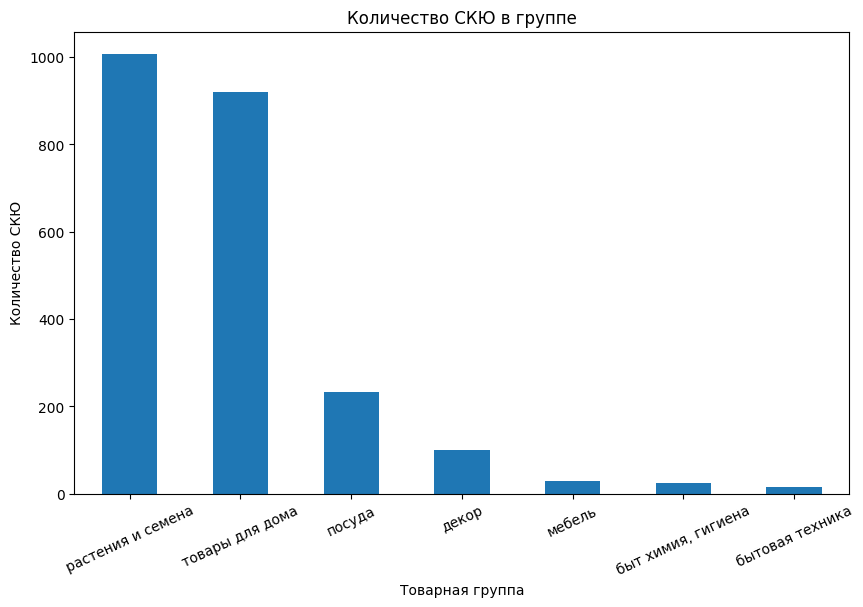

In [114]:
# построим график с распределением товарных позиций по группам
plt.figure(figsize=(10, 6))
df.groupby('group')['product'].nunique().sort_values(ascending = False).plot(kind = 'bar')
plt.title(f'Количество СКЮ в группе')
plt.xlabel('Товарная группа')
plt.ylabel (f'Количество СКЮ')
plt.xticks(rotation=25)
plt.show()

Основа ассортимента магазина - Растерия и семена. Также в топ-3 товарных групп входят товары для дома и посуда.

**Визуализируем исторические данные по количеству клиентов, заказов и по суммам покупок**

In [115]:
history_pivot = df.pivot_table(index = 'year_month', values = ['customer_id', 'order_id'], aggfunc = 'nunique')

In [116]:
history_pivot

,customer_id,order_id
year_month,,
2018-10,179,238
2018-11,178,204
2018-12,228,278
2019-01,149,165
2019-02,244,286
2019-03,227,242
2019-04,235,264
2019-05,164,178
2019-06,147,156


<Figure size 1000x600 with 0 Axes>

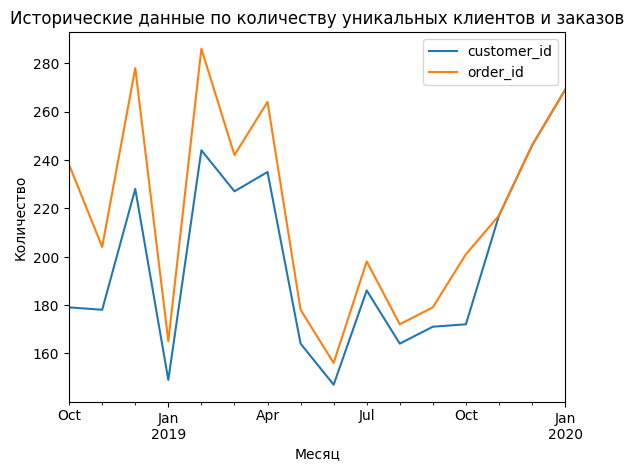

In [117]:
# построим график с распределением товарных позиций по группам
plt.figure(figsize=(10, 6))
history_pivot.plot()
plt.title(f'Исторические данные по количеству уникальных клиентов и заказов')
plt.xlabel('Месяц')
plt.ylabel (f'Количество')
plt.show();

На графике видно, что в последние три месяца резко растет количество заказов и клиентов.
При этом их количество совпадает между собой, т.е. клиент делает всего один заказ в месяц (возможно единственный за весь жизненный цикл).

Причина может быть в том, что компания стимулирует проведение первого заказа скидками и промокодами. Клиент, совершивгий единичную покупку со скидкой больше не возвращается. Возможно существует проблема отсутствия постоянной клиентской базы.

Проверим, как данная ситуация отражается на сумме выручки.

In [118]:
history_pivot_purchase = df.pivot_table(index = 'year_month', values = 'purchase', aggfunc = 'sum')

<Figure size 1000x600 with 0 Axes>

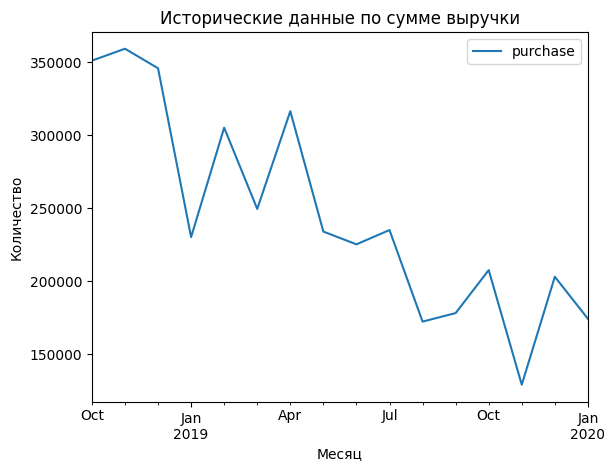

In [119]:
plt.figure(figsize=(10, 6))
history_pivot_purchase.plot()
plt.title(f'Исторические данные по сумме выручки')
plt.xlabel('Месяц')
plt.ylabel (f'Количество')
plt.show();

В исследуемый период наблюдается снижение размера выручки. Минимальное значение было достигнуто с ноябре 2019 года.
Увеличение количества клиентов в период последних трех месяцев дало некоторый положительный эффект, но в январе размер выручки снова показал падение.

**Расчитаем длительность жизненного цикла клиента и выведем основную статистику**

In [120]:
lifetime_pivot = df.pivot_table(index = 'customer_id', values = 'date', aggfunc = ['min', 'max']).reset_index()
lifetime_pivot['lifetime_days'] = lifetime_pivot['max'] - lifetime_pivot ['min']

In [121]:
lifetime_pivot['lifetime_days'].describe()

count                           2412
mean      79 days 11:45:40.298507463
std      127 days 04:09:49.952758502
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%                167 days 06:00:00
max                395 days 00:00:00
Name: lifetime_days, dtype: object

Максимальная продолжительность жизненного цикла клиента - 395 дней.
Большая доля клиентов (более 50%) имеют продолжительность жизненного цикла 0 дней, т.е. с большой вероятностью сделали всего одну покупку.
Средняя продолжительность жизненного цикла - 79 дней.
Для 75% клиентов продолжительность жизненного цикла составляет 167 дней, т.е. менее полугода.

Средний чек по заказу составляет 1121 у.е, медианный - 580 у.е

Динамика количества клиентов и числа уникальных заказов положительная. Однако в послежние три месяца наблюдается тенденция - количество азаказов равно количеству клиентов, а это значит, что клиент делает всего один заказ и уходит в отток.

При этом наблюдается снижение размера выручки - в течение всего периода исследования.

Исходя и того, что жиненный цикл 75% клиентов не превышает полугода, а клиенты, совершившие последнюю покупку более полугода назад - ушли в отток, принято решение проводить сегментацию на основе актуальных данных.

Актуальный период исследования для кластеризации - последние шесть месяцев наблюдений, начиная с 01.08.2019 включительно.


### вывод по разделу

В ходе исследовательского анализа данных была получена основная статистика об активности клиентов.
Для 75% записей количество заказанного тавара - 1 штука.
Максимальное значение единовременного заказа 1000 шт.
Минимальная цена товара - 9 у.е, медиана - 150 у.е, среднее - 531,58 у. е. Максимальная цена товара 14917 у.е.
Минимальная сумма единовременной покупки одной СКЮ - 9 у.е, максимальная - 675 000 у.е. 75% покупок не превышает сумму 734 у.е.

Были проверены проверим выбросы по количеству единовременно заказанного товара (из датафрейма удален выброс с записью о покупке 1000ед товара). Некорректные данные по ценам товара не обнаружены - цены находятся в предела рынка.

Определен основной ассортимент магазина - растения и семена, а также товары для дома и посуда.

Датасет включает прериод наблюдений с 01 октября 2018 года по 31 января 2020 года.

## Сегментация клиентов на основе RFM-анализа:

RFM анализ проведем на основе актуальных данных о покупках за последние пол года.

In [122]:
# отфильтруем датасет для проведения анализа
df_rfm = df[df['year_month'] > '2019-07']

In [123]:
# проверим результат
df_rfm ['year_month'].value_counts()

2020-01    269
2019-12    246
2019-09    217
2019-10    217
2019-11    217
2019-08    199
Freq: M, Name: year_month, dtype: int64

In [124]:
# переведем данные в формат даты-времени
df_rfm['date']= pd.to_datetime(df_rfm['date'])

Для проведения rfm анализа расчитаем предварительные данные для кажой метрики:

    - Recency (Давность) — Как давно клиент совершил покупку?
    - Frequency (Частота) — Как часто он совершает покупки?
    - Monetary Value (Денежная ценность) — Сколько он тратит?

Затем объединим данные в единую таблицу и присвоим каждому клиенту ранг от 1 до 3 в разрезе каждой метрики.
Значение 1 будет обозначать в анном случае максимально благоприятную ситуацию (недавно севершенная покупка/частые покупки/высокая стоимость покупки). Значение 3 - наименее благоприятное (давно и мало).

**Расчет данных для определения параметра R (recency) для каждого клиента**

Параметр R определяет давность совершения последней покупки.
Он определяет статус активности клиента на текущий момент.
Предварительно расчитаем количество дней, прошедших

In [125]:
#сгруппируем датафрейм по полю customer_id. Для каждого клиента выведеи самую позднюю дату совершения покупки
r = df_rfm.groupby('customer_id')['date'].max().reset_index()

In [126]:
# вычислим количество дней, которое прошло с даты последней покупки до даты окончания наблюдений
r['recency'] = abs(pd.to_datetime(r['date']) - pd.to_datetime('2020-01-31'))

In [127]:
# объявим функцию, которая отсечет количество целых дней, которое прошло с даты последней покупки до даты окончания наблюдений
def recency(recency):
    res = str(recency).split(' ')[0]
    return(int(res))

# применим функцию
r['recency'] = r['recency'].apply(recency)

In [128]:
# для проверки результата выведем первые 5 строк полученной таблицы
r.head()

,customer_id,date,recency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16,107
1,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14,109
2,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29,124
3,005ba170-45e8-42de-93f7-192481ae2659,2019-11-05,87
4,00c0f92a-121a-4883-a78d-2c7b5fe187de,2019-12-12,50


In [129]:
# удалим вспомогательный столбец с датой, для дальнейшего корректного объединения таблиц
r = r.drop('date',axis = 1)

In [130]:
# для проверки результата выведем первые 5 строк полученной таблицы
r.head()

,customer_id,recency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,107
1,00299f34-5385-4d13-9aea-c80b81658e1b,109
2,003bbd39-0000-41ff-b7f9-2ddaec152037,124
3,005ba170-45e8-42de-93f7-192481ae2659,87
4,00c0f92a-121a-4883-a78d-2c7b5fe187de,50


**Расчет данных для определения параметра F (frequency) для каждого клиента**

In [131]:
# расчитываем метрику f (частота совершения покупки). Для этого посчитаем количество совершенных заказов каждым клиентом
f = df_rfm.groupby('customer_id')['order_id'].count().reset_index()
f

,customer_id,order_id
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4
1,00299f34-5385-4d13-9aea-c80b81658e1b,1
2,003bbd39-0000-41ff-b7f9-2ddaec152037,1
3,005ba170-45e8-42de-93f7-192481ae2659,1
4,00c0f92a-121a-4883-a78d-2c7b5fe187de,1
...,...,...
1113,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,1
1114,ff601403-b094-4b86-9ac6-264d725b9277,2
1115,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1
1116,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1


**Расчет данных для определения параметра M (Monetary) для каждого клиента**

In [132]:
# расчитаем метрику m
m = df_rfm.groupby('customer_id')['purchase'].sum()
m = pd.DataFrame(m).reset_index()
m

,customer_id,purchase
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0
1,00299f34-5385-4d13-9aea-c80b81658e1b,914.0
2,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0
3,005ba170-45e8-42de-93f7-192481ae2659,6658.0
4,00c0f92a-121a-4883-a78d-2c7b5fe187de,187.0
...,...,...
1113,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,899.0
1114,ff601403-b094-4b86-9ac6-264d725b9277,1739.0
1115,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,397.0
1116,ffb80538-3fda-4351-8ea9-9d2bec58bb07,974.0


**Объединим полученные таблицы**

In [133]:
# объединяем методом merge()
finaldf = r.merge(f,on='customer_id').merge(m,on='customer_id')

In [134]:
# выведем основную статистику по полученным данным
finaldf.describe()

,recency,order_id,purchase
count,1118.000000,1118.000000,1118.000000
mean,74.400716,1.220930,950.988745
std,49.972692,0.894843,1552.468484
min,0.000000,1.000000,9.000000
25%,31.000000,1.000000,134.000000
50%,68.000000,1.000000,389.000000
75%,111.000000,1.000000,1087.000000
max,183.000000,17.000000,21361.000000


**Присвоим ранги по значению r**

In [135]:
# используем метод pd.qcut() для автоматического распределения значений по равным группам
finaldf ['r'] = pd.qcut(finaldf ['recency'], 3, labels = False) + 1

In [136]:
# проверим результат распределения
finaldf.groupby('r')['customer_id'].count()

r
1    376
2    377
3    365
Name: customer_id, dtype: int64

Распределение произошло на 3 примерно равные группы. Проверим границы распределения на соответствие задаче

In [137]:
print (f'Границы группы 1')
finaldf [finaldf['r'] == 1]['recency'].describe()[['min','max']]

Границы группы 1


min     0.0
max    42.0
Name: recency, dtype: float64

In [138]:
print ('Границы группы 2')
finaldf [finaldf['r'] == 2]['recency'].describe()[['min','max']]

Границы группы 2


min    43.0
max    93.0
Name: recency, dtype: float64

In [139]:
print ('Границы группы 3')
finaldf [finaldf['r'] == 3]['recency'].describe()[['min','max']]

Границы группы 3


min     94.0
max    183.0
Name: recency, dtype: float64

Данная градация выглядит соответствующей поставленной задачи. Оставляем ее для проведения анализа

**Присвоим ранги по значению f**

Из-за неравномерности распределения данных, автоматическое распределение данных невозможно.
Выведем сводную таблицу для определения оптимального деления клиентов на группы по количеству совершенных покупок.

In [140]:
finaldf['order_id'].value_counts()

1     950
2     150
4       4
5       4
3       4
9       2
10      1
14      1
17      1
8       1
Name: order_id, dtype: int64

На основании полученной таблицы присвоим следующие ранги:
    
    1 совершенная покупка - 3 ранг
    2 совершенные покупки - 2 ранг
    3 и более совершенных покупок - 1 ранг - постояные клиенты

In [141]:
# объявим функцию классификации
def get_f(x):
    if x == 1:
        return 3
    if x == 2:
        return 2
    if x >= 3:
        return 1

In [142]:
# применим функцию на таблице с данными о количестве заказов и прверим результат распределения
finaldf['f'] = list(map (get_f, finaldf['order_id']))
finaldf['f'].value_counts()

3    950
2    150
1     18
Name: f, dtype: int64

**Присвоим ранги по значению m**

Для определения границ групп выведем основную статистику по суммам покупок клиентов




In [143]:
# основная статистика
finaldf['purchase'].describe()

count     1118.000000
mean       950.988745
std       1552.468484
min          9.000000
25%        134.000000
50%        389.000000
75%       1087.000000
max      21361.000000
Name: purchase, dtype: float64

Text(0.5, 1.0, 'Распределение сумм выручки от каждого клиента')

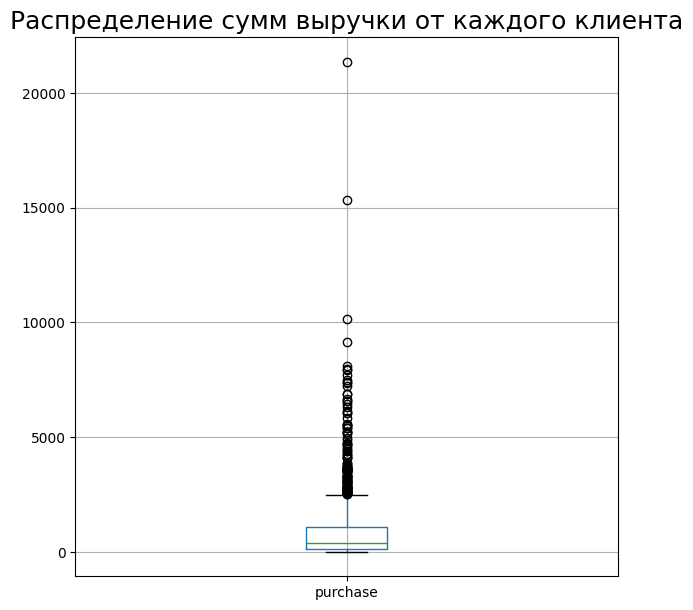

In [144]:
# боксплот с распределением
plt.figure(figsize = (7, 7))
finaldf.boxplot(['purchase'])
plt.title(f'Распределение сумм выручки от каждого клиента', fontsize = 18)

Определим границу группы 1 на уровне 2500 у.е - по примерной границе начала выбросов на графике
Группа 2 будет присвоена от примерной границы 75 процентили (1000 у.е)
Группа 1 - менее 1000 у.е - это клиенты с минимальными покупками

In [145]:
# объявим функцию распределения по группам для показателя m (monetary)
def get_m(x):
    if x < 1000:
        return 3
    if 1000 <= x < 2500:
        return 2
    if x >= 2500:
        return 1

In [146]:
finaldf['m'] = list(map (get_m, finaldf['purchase']))
finaldf['m'].value_counts()

3    807
2    192
1    119
Name: m, dtype: int64

In [147]:
# проверим результат добавления столбцов
finaldf.head()

,customer_id,recency,order_id,purchase,r,f,m
0,000d6849-084e-4d9f-ac03-37174eaf60c4,107,4,555.0,3,1,3
1,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,3,3,3
2,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,3,3,2
3,005ba170-45e8-42de-93f7-192481ae2659,87,1,6658.0,2,3,1
4,00c0f92a-121a-4883-a78d-2c7b5fe187de,50,1,187.0,2,3,3


In [148]:
#Сформируем оценку rfm для каждого клиента
finaldf['rfm_score'] = finaldf['r'].astype(str) + finaldf['f'].astype(str) + finaldf['m'].astype(str)
finaldf['rfm_score'] = finaldf['rfm_score'].astype(int)

In [149]:
# проверим распределение количества клиентов по категориям и расчитаем долю каждой группы
pivot_of_rfm = finaldf.groupby('rfm_score')['customer_id'].count().reset_index()
pivot_of_rfm ['perc'] = round((pivot_of_rfm ['customer_id'] / pivot_of_rfm ['customer_id'].sum())*100)
pivot_of_rfm

,rfm_score,customer_id,perc
0,121,23,2.0
1,122,39,3.0
2,123,56,5.0
3,131,21,2.0
4,132,35,3.0
5,133,202,18.0
6,211,1,0.0
7,222,1,0.0
8,223,2,0.0
9,231,23,2.0


Основная часть клиентов относится к группе *33

65% клиентов cовершеют редкие покупки в разной степени давности на небольшую сумму

### вывод по разделу

Произведена сегментация клиентов на основе rfm анализа.

**Параметр r, давность совершения покупки**

Группа 1: 0-42 дня

Група 2: 43-93 дня

Группа 3: 94-183 дня

**Параметр f, частота совершения покупок:**

Группа 1: более 3 покупок

Группа 2: 2 покупки

Группа 2: 1 покупка

**Параметр m, сумма всех совершенных покупок**

Группа 1: более 2500 у.е

Группа 2: от 1000 до 2500 у.е

Группа 3: до 1000 у.е

Добавляем оценку клиентов в датафрейм с историей покупок

In [150]:
# добоавим столбец с кластеризацией клиентов в основной датафрейм
df_rfm_final = df_rfm.merge(finaldf[['customer_id', 'rfm_score']],on='customer_id')
df_rfm_final.head(1)

,date,customer_id,order_id,product,quantity,price,year_month,time,purchase,product_cut,group,rfm_score
0,2019-08-01,f0054c60-0290-4608-b04f-84778d144bcd,72164,сушилка для белья потолочная zalger lift basic...,1,614.0,2019-08,07:00:00,614.0,сушилка для,товары для дома,123


## Формирование гипотез о поведении различных групп пользователей



    Для проверки корректности разбиения на кластеры сравним средние показатели параметров для раличных групп:

   **По параметру r проверим:**
   
   *Нулевую гипотезу H0* о равенстве среднего количества дней, прошедшего с даты последнего заказа между группами 1,2 и 3.
   
   *Альтернативная гипотеза:* среднее количество дней, прошедшее со дня последнего заказа между группами 1,2 и 3 отличаются.
    
   **По параметру f проверим:**
   
   *Нулевую гипотезу H0* о равенстве среднего количества заказов между группами 1,2 и 3.
   
   *Альтернативная гипотеза:* среднее количество заказов между группами 1,2 и 3 отличаются.
    
   **По параметру m проверим**:
   
   *Нулевую гипотезу H0* о ревенстве средней суммы трат между группами 1,2 и 3.
   
   *Альтернативная гипотеза:* средняя сумма трат между группами 1,2 и 3 отличаются.
   
   
    Если средние показатели в различных группах раличаются статистически значимо, то разбиение выполнень корректно.
    Если статистически значимых отличий между группами нет - необходмо провести рабиение повторно.

Для сравнения соедних начений трех групп необходимо провести серию попарных сравнений между группами: 1-2, 2-3, 1-3.
Чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости применим поправку Бонферрони

### Гипотеза 1
Нулевая гипотезу H0 о равенстве среднего количества заказов между группами 1,2 и 3.

Альтернативная гипотеза: среднее количество заказов между группами 1,2 и 3 отличаются

In [151]:
# отфильтруем данные из полученного датасета по группам
# деление по группам по параметру r

sample_1 = finaldf [finaldf ['r'] == 1]['recency']

sample_2  = finaldf [finaldf ['r'] == 2]['recency']

sample_3 = finaldf [finaldf ['r'] == 3]['recency']

alpha = 0.05  # критический уровень статистической значимости

results_12 = st.ttest_ind(sample_1, sample_2)

results_23 = st.ttest_ind(sample_2, sample_3)

results_13 = st.ttest_ind(sample_1, sample_3)

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп 1 и 2: ', results_12.pvalue)
print('p-значение для сравнения групп 2 и 3: ', results_23.pvalue)
print('p-значение для сравнения групп 1 и 3: ', results_13.pvalue)

if results_12.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 2')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 2'
    )

if results_23.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 2 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 2 и 3'
    )

if results_13.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 3'
    )

p-значение для сравнения групп 1 и 2:  6.65447045676063e-229
p-значение для сравнения групп 2 и 3:  9.664461551810887e-201
p-значение для сравнения групп 1 и 3:  0.0
Отвергаем нулевую гипотезу для сравнения групп 1 и 2
Отвергаем нулевую гипотезу для сравнения групп 2 и 3
Отвергаем нулевую гипотезу для сравнения групп 1 и 3


Распределение по группам по параметру r проведено корректно. Средние значения между группами отличаются.

### Гипотеза 2
Нулевая гипотеза H0 о равенстве среднего количества заказов между группами 1,2 и 3.

Альтернативная гипотеза: среднее количество заказов между группами 1,2 и 3 отличаются.

In [152]:
# отфильтруем данные из полученного датасета по группам
# деление по группам по параметру f

sample_1 = finaldf [finaldf ['f'] == 1]['order_id']

sample_2  = finaldf [finaldf ['f'] == 2]['order_id']

sample_3 = finaldf [finaldf ['f'] == 3]['order_id']

alpha = 0.05  # критический уровень статистической значимости

results_12 = st.ttest_ind(sample_1, sample_2)

results_23 = st.ttest_ind(sample_2, sample_3)

results_13 = st.ttest_ind(sample_1, sample_3)

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп 1 и 2: ', results_12.pvalue)
print('p-значение для сравнения групп 2 и 3: ', results_23.pvalue)
print('p-значение для сравнения групп 1 и 3: ', results_13.pvalue)

if results_12.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 2')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 2'
    )

if results_23.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 2 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 2 и 3'
    )

if results_13.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 3'
    )

p-значение для сравнения групп 1 и 2:  6.805077973474879e-29
p-значение для сравнения групп 2 и 3:  0.0
p-значение для сравнения групп 1 и 3:  2.0423970914289513e-222
Отвергаем нулевую гипотезу для сравнения групп 1 и 2
Отвергаем нулевую гипотезу для сравнения групп 2 и 3
Отвергаем нулевую гипотезу для сравнения групп 1 и 3


Распределение по группам по параметру f проведено корректно. Средние значения между группами отличаются.

### Гипотеза 3

Нулевая гипотеза H0 о ревенстве средней суммы трат между группами 1,2 и 3.

Альтернативная гипотеза: средняя сумма трат между группами 1,2 и 3 отличаются.

In [153]:
# отфильтруем данные из полученного датасета по группам
# деление по группам по параметру m

sample_1 = finaldf [finaldf ['m'] == 1]['purchase']

sample_2  = finaldf [finaldf ['m'] == 2]['purchase']

sample_3 = finaldf [finaldf ['m'] == 3]['purchase']

alpha = 0.05  # критический уровень статистической значимости

results_12 = st.ttest_ind(sample_1, sample_2)

results_23 = st.ttest_ind(sample_2, sample_3)

results_13 = st.ttest_ind(sample_1, sample_3)

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп 1 и 2: ', results_12.pvalue)
print('p-значение для сравнения групп 2 и 3: ', results_23.pvalue)
print('p-значение для сравнения групп 1 и 3: ', results_13.pvalue)

if results_12.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 2')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 2'
    )

if results_23.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 2 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 2 и 3'
    )

if results_13.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп 1 и 3')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп 1 и 3'
    )

p-значение для сравнения групп 1 и 2:  5.884131760585416e-43
p-значение для сравнения групп 2 и 3:  9.467424437573888e-288
p-значение для сравнения групп 1 и 3:  6.825717698112745e-242
Отвергаем нулевую гипотезу для сравнения групп 1 и 2
Отвергаем нулевую гипотезу для сравнения групп 2 и 3
Отвергаем нулевую гипотезу для сравнения групп 1 и 3


Распределение по группам по параметру f проведено корректно. Средние значения между группами отличаются.

## Рекомендации по каждой из групп пользователей


**Описание сегментов и рекомендации по взаимодействию с ними**

**Сегмент оттока**

Этот сегмент включает тех, кто давно не покупал или купил лишь однажды, но больше не вернулся.

**331, 332, 333**

Разовые клиенты, которые не продолжили взаимодействие с брендом после первой покупки.	Эти клиенты, скорее всего, не вернутся. На всякий случай им можно отправить реактивационную рассылку с промокодом. Если они не читают рассылки более года, их можно удалить из базы.

**321, 322, 323**

Клиенты, покупавшие время от времени, но нерегулярно. Возможно, они покупают в том числе у конкурентов.	В случае с этим сегментом важно понять, что поможет клиенту обращаться к вам чаще. Накопительные скидки или индивидуальные предложения со скидками могут мотивировать клиента вернуться к вам от конкурентов.

**311, 312, 313**

Раньше этим клиентам нравился продукт, потому что они его часто покупали. Но по какой-то причине они перестали это делать.	Таких клиентов следует вернуть. Это можно сделать с помощью рассылки, в которой будет информация о скидках, программе лояльности и так далее.


**Пассивные клиенты**
Это клиенты, которые покупали не слишком давно, поэтому, вероятно, их еще можно вернуть.

**221, 222, 223, 231, 232, 233**

Сюда входят относительно недавние клиенты, которые покупают с разной частотой и на разную сумму. Эти клиенты находятся в средней зоне — они могут стать постоянными, а могут уйти в сегмент оттока.	Важно вовремя присылать персональные подборки и предложения скидок, чтобы поддерживать интерес клиентов к бренду.

**213, 212, 211**

Относительно недавние клиенты, которые часто покупали, но потом перестали.	Можно провести опрос, чтобы выяснить, почему клиент перестал покупать. После этого стоит попытаться его вернуть, предлагая бонусы или промокоды.


**Активные клиенты**
Сюда входят клиенты, которые только познакомились с брендом или покупали недавно.

**131, 132, 133**

Это новые клиенты, которые недавно совершили одну-две покупки.	Для новичков обязательно должны быть прогревающие цепочки, подробно рассказывающие о бренде.

**121, 122, 123**

Это активные клиенты, которые покупают время от времени на разную сумму.
Нужно поддерживать интерес клиентов к товарам: сообщать про новинки, отправлять предложения с сопутствующими товарами или аксессуарами к тем товарам, которые они уже купили.

Постоянных клиентов, которые недавно совершили покупку, стоит регулярно спрашивать их мнение о покупке, чтобы вовремя понять, что что-то пошло не так.

**113**

Постоянные клиенты, которые готовы регулярно покупать.	Для сегмента с маленьким чеком можно попробовать увеличить сумму с помощью акций — например, купи на сумму N и получи подарок или скидку.

**112**

Сегменту со средним чеком стоит отправлять персональные подборки и акции, чтобы поддерживать интерес.

**111**

VIP-клиентам, которые покупают постоянно и на большие суммы, следует уделить особое внимание. Возможно, сделать особую систему привилегий и сервисов или предоставить персонального менеджера.

###Свойства разлиxных групп пользователей

In [154]:
#выведем топ-5 групп по численности клиентов и сформулируем рекомендации для данных групп
top_5 = pivot_of_rfm.sort_values(by = 'perc', ascending = False).head(5)
share_top_5 = top_5['perc'].sum()
print(top_5)
print(f'Доля пользователей топ-5 групп клиентов по численности составляет {share_top_5}%')

    rfm_score  customer_id  perc
11        233          309  28.0
20        333          212  19.0
5         133          202  18.0
19        332           67   6.0
2         123           56   5.0
Доля пользователей топ-5 групп клиентов по численности составляет 76.0%


In [155]:
# отфильтруем ТОП-5 категорий клиетов
df_top_5 = df_rfm_final[df_rfm_final['rfm_score'].isin(top_5['rfm_score'])].sort_values(by = ['rfm_score', 'group'])

In [156]:
# объявим функцию визуализации структуры потребления (количество купленных товаров) по группам пользователей
def pie_function(df, user_group):
    colors = sns.color_palette('pastel')[ 0:7]
    df[df['rfm_score'] == user_group].groupby(['group'])['quantity'].sum().rename('').plot(kind='pie', autopct='%1.0f%%',colors = colors, title=f'Структура покупок по товарным группам, пользователи группы {user_group}')

    plt.show()

___

**Выведем структуру потребления по количеству купленных товаров по группам пользователей**

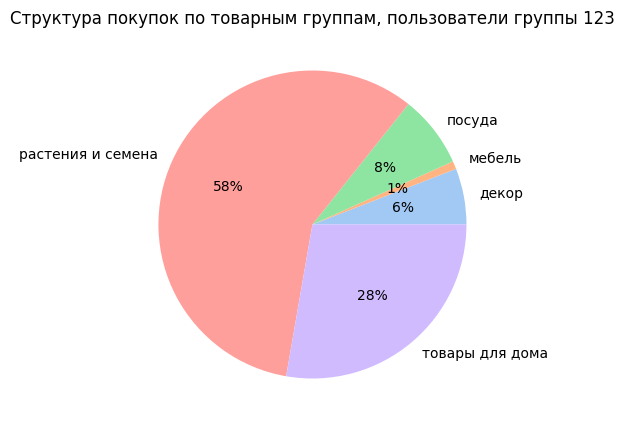

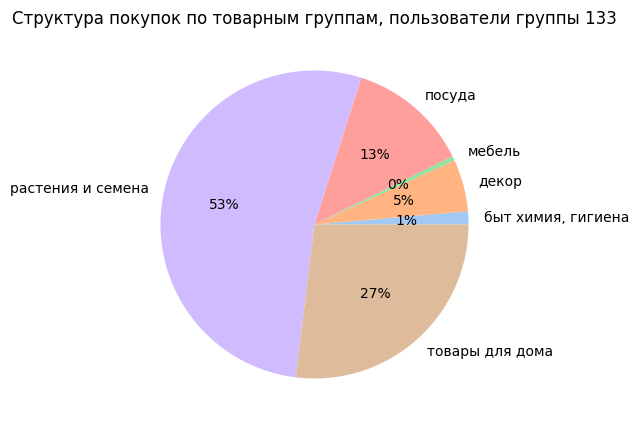

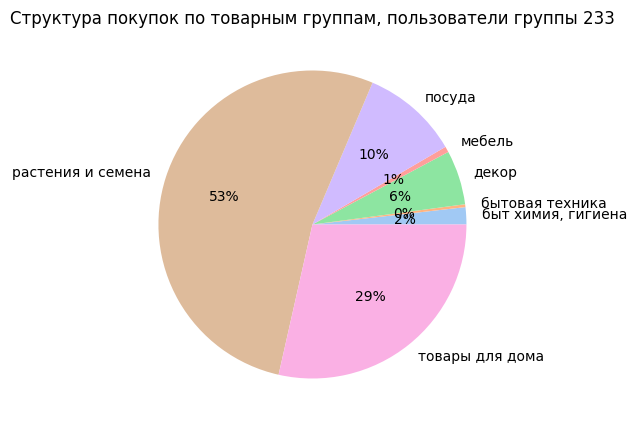

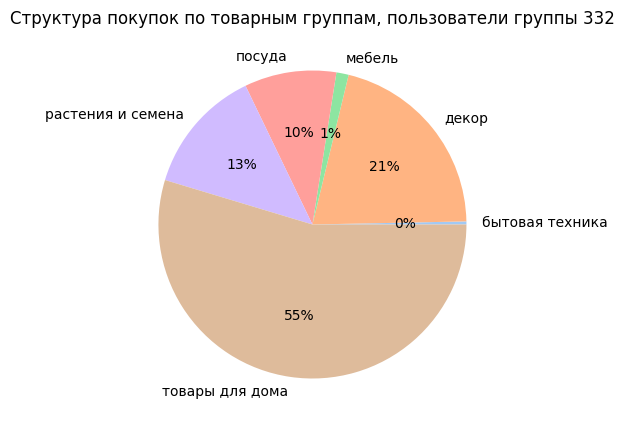

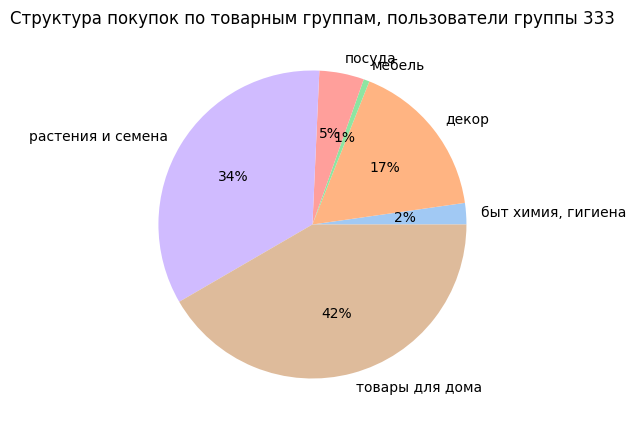

In [157]:
# список топ-5 групп пользователей
user_groups = list(df_top_5['rfm_score'].unique())

# применим функцию визуалиации для топ-5 групп пользователей
for group in user_groups:
    plt.figure (figsize = (5, 5))
    pie_function (df_top_5, group)
    plt.show()

На графиках выше выведена структура потребления раличных групп пользователей.
Основную долю в структуре потребления составляют Товары для дома и Растения и семена.

Основная доля недавних пользователей чаще всего совершала покупки в категории Растения и семена (категории по давности 1 и 2).
Более давние пользователи в основном совершали покупки в категории Товары для дома.


___

**Выведем частоту совершения заказов по дням недели в разрезе пользовательских групп**

In [158]:
# добавим в датафрейм поле с днем недели заказа, чтобы увидеть в какие дни недели чаще всего происходят заказы у пользователей топ-5 групп
df_top_5['weekday'] = pd.to_datetime(df_top_5['date']).dt.weekday

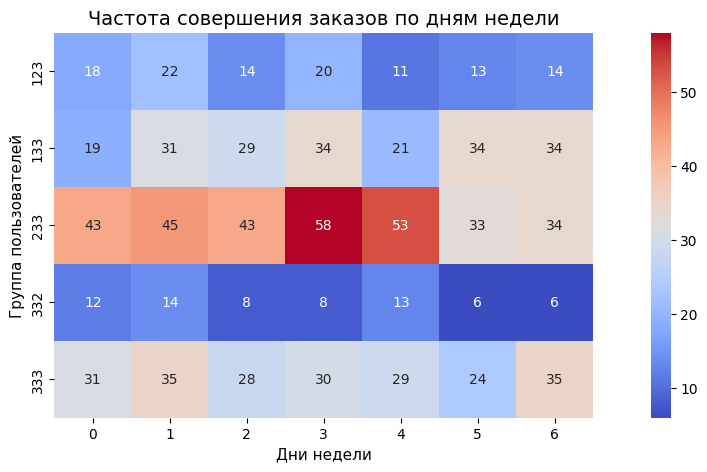

In [159]:
# выведем динамику заказов различных групп пользователей по неделям
plt.figure(figsize=(15, 5))
pt_wd = df_top_5.pivot_table(index = 'rfm_score', columns = 'weekday', values = 'order_id', aggfunc = 'nunique')
sns.heatmap(pt_wd, cmap='coolwarm', annot=True, square=True)
plt.title(f'Частота совершения заказов по дням недели', fontsize=14)
plt.xlabel('Дни недели', fontsize=11)
plt.ylabel('Группа пользователей', fontsize=11)
plt.show()

Выше выведена тепловая карта с частотой заказов по дням недели в разрезе групп пользователей.
Соответствие дней недели от 0 - понедельник до 6 - воскресение.

На графике видно, что частота совершения заказов по дням недели для различных групп отличается.
Недавние пользователи с повторными заказами - группа 123 - наибольшая частота заказов приходится на вторник и четверг.
Недавние единичные заказы - группа 133 - четверг, суббота, воскресение.

Наибольшее количество заказов принадлежит группе единичных заказов средней давности - наибольшее число заказов в четверг и пятницу. Проседание на выходных днях.

Группа оттока - наибольшее число заказов во вторник и в воскресение.

___

**Выведем частоту совершения заказов по времени в разрезе пользовательских групп**

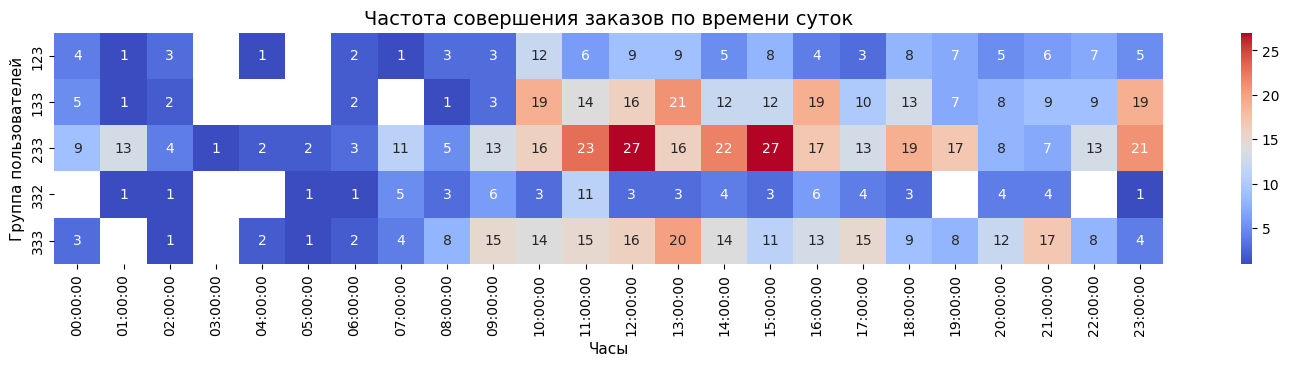

In [160]:
pt = df_top_5.pivot_table(index = 'rfm_score', columns = 'time', values = 'order_id', aggfunc = 'nunique')
plt.figure(figsize=(20, 3))
sns.heatmap(pt , cmap='coolwarm', annot=True, square=True)
plt.title(f'Частота совершения заказов по времени суток', fontsize=14)
plt.xlabel('Часы', fontsize=11)
plt.ylabel('Группа пользователей', fontsize=11)
plt.show()


Наибольшее число заказов приходится на утреннее и  обеденное время - с 10 часов утра, до 19 часов вечера. Также наблюдается подъем количества заказов в 23 часа.

Практически отсутствуют заказы с 2 часов ночи до 6 утра. также снижение пользовательской активности наблюдается с 20 до 22 часов.

Видно, что различным пользовательским группам свойственно различное проявление активности в течение суток, а также в течение недели.

По распределению видно, что привлечение новых клиентов происходит успешно.
Основная проблема состоит в удержании внимания пользователя и мотивации на повторную покупку.

Проблема может заключаться в:

    - отсутствии информированности о наличии интересного клиенту ассортимента,
    - в фактическом отсутствии интересного клиенту ассортимента,
    - уровне сервиса магазина,
    - качестве товара.

### Рекомендации для различных групп пользователей

**Отток**

Группы: 333, 332 - клиенты, совершившие единоразовую покупку давно, на небольшую или среднюю сумму
Рекомендация - проведение реактивационной рассылки промокодами.

**Пассивные клиенты**

Группа 233 - рекомендуется предложение персональных подборок и скидок, чтобы поддерживать интерес клиентов к бренду.
Клиенты потенциально могут стать постоянными клиентами.

**Активные клиенты**

Группа 133 - новички, совершившие одну покупку рассылка прогревающей цепочки уведомлений, создающей интерес к магазину

Группа 123 - клиенты, совршившие недавно вторую покупку. Для данных клиентов необходимо поддерживать интерес к товарам: сообщать про новинки, отправлять предложения с сопутствующими товарами или аксессуарами к тем товарам, которые они уже купили.


## Итоговый вывод

**Проведена предобработка данных:**

Исходный датасет содержит 7474 строк. Пропусков нет. Явные дубликаты не обнаружены.

Обнаружены скрытые дубликаты в разрезе номер заказа/клиент/СКЮ. Доля дублей составляет 25.23%. Причина аномалия в данных, заказы задублированны на различные даты. В датасете оставлены данные на наиболее ранюю дату.

Также обнаружена аномалия в данных. К одному заказу подвязны несколько номеров клиентов. Т.к. принадлежность к конкретному пользователю определить невозможно, данные удалены из датасета. Доля удаленны данных от исходного датета составила 0.88%.

По итогу обработки дубликатов в датасете осталось 5522 строк, что составляет 73.88% исходного датасета.

Произведено изменение формата для столбца date - перевод в datetime. Столбец разделен на два, содержащий отдельно дату(date) и время (time).

Дополнительно в отдельном столбце purchase расчитана сумма покупки на основании столбцов price и quantity.

**В ходе исследовательского анализа данных выявлено:**

Максимальная продолжительность жизненного цикла клиента - 395 дней. Большая доля клиентов (более 50%) имеют продолжительность жизненного цикла 0 дней, т.е. с большой вероятностью сделали всего одну покупку. Средняя продолжительность жизненного цикла - 79 дней. Для 75% клиентов продолжительность жизненного цикла составляет 167 дней, т.е. менее полугода.

Средний чек по заказу составляет 1121 у.е, медианный - 580 у.е

Динамика количества клиентов и числа уникальных заказов положительная. Однако в послежние три месяца наблюдается тенденция - количество азаказов равно количеству клиентов, а это значит, что клиент делает всего один заказ и уходит в отток.

При этом наблюдается снижение размера выручки - в течение всего периода исследования.

Исходя и того, что жиненный цикл 75% клиентов не превышает полугода, а клиенты, совершившие последнюю покупку более полугода назад - ушли в отток, принято решение проводить сегментацию на основе актуальных данных.

**Актуальный период исследования для кластеризации - последние шесть месяцев наблюдений, начиная с 01.08.2019 включительно.**

Для проведения rfm анализа существуют следующие параметры градации:

- Recency (Давность) — Как давно клиент совершил покупку?
- Frequency (Частота) — Как часто он совершает покупки?
- Monetary Value (Денежная ценность) — Сколько он тратит?

Каждому каждому клиенту был присвоен ранг от 1 до 3 в разрезе каждой метрики.

Значение 1  обозначает  максимально благоприятную ситуацию (недавно севершенная покупка/частые покупки/высокая стоимость покупки). Значение 3 - наименее благоприятное (давно и мало).

**Границы сегментов**

**Параметр r, давность совершения покупки**

Группа 1: 0-42 дня

Група 2: 43-93 дня

Группа 3: 94-183 дня

**Параметр f, частота совершения покупок:**

Группа 1: более 3 покупок

Группа 2: 2 покупки

Группа 2: 1 покупка

**Параметр m, сумма всех совершенных покупок**

Группа 1: более 2500 у.е

Группа 2: от 1000 до 2500 у.е

Группа 3: до 1000 у.е

**Для проверки корректности границ распределения были сформулированы и проверены гипотезы о равенстве средних показателей.**

Использован ttest с уровнем начимости 0,05. Т.к. была произведена множественная проверка, была использована поправка Бонферрони.

*По параметру r проверена:*

Нулевая гипотеза H0 о равенстве среднего количества дней, прошедшего с даты последнего заказа между группами 1,2 и 3.

Альтернативная гипотеза: среднее количество дней, прошедшее со дня последнего заказа между группами 1,2 и 3 отличаются.

*По параметру f проверена:*

Нулевая гипотеза H0 о равенстве среднего количества заказов между группами 1,2 и 3.

Альтернативная гипотеза: среднее количество заказов между группами 1,2 и 3 отличаются.

*По параметру m проверена:*

Нулевая гипотеза H0 о ревенстве средней суммы трат между группами 1,2 и 3.

Альтернативная гипотеза: средняя сумма трат между группами 1,2 и 3 отличаются.

**По всем параметрам приняты альтернативные гипотезы, т.е. границы кластеров установлены корректно.**

Выявлены Топ 5 групп пользователей и их доли в общем массиве клиентов:

    - Группа 233 - 28.0 %
    - Группа 333 - 19.0 %
    - Группа 133 - 18.0 %
    - Группа 332 - 6.0 %
    - Группа 123 - 5.0 %
Суммарная доля пользователей топ-5 групп клиентов по численности составляет 76.0%

Основную долю в структуре потребления для всех групп составляют Товары для дома и Растения и семена.

Основная доля недавних пользователей чаще всего совершала покупки в категории Растения и семена (категории по давности 1 и 2).
Более давние пользователи в основном совершали покупки в категории Товары для дома.

Частота совершения заказов по дням недели для различных групп отличается.
Недавние пользователи с повторными заказами - группа 123 - наибольшая частота заказов приходится на вторник и четверг.
Недавние единичные заказы - группа 133 - четверг, суббота, воскресение.

Наибольшее количество заказов принадлежит группе единичных заказов средней давности - наибольшее число заказов в четверг и пятницу. Проседание на выходных днях.

Группа оттока - наибольшее число заказов во вторник и в воскресение.

Наибольшее число заказов приходится на утреннее и  обеденное время - с 10 часов утра, до 19 часов вечера. Также наблюдается пожъем количества заказов в 23 часа.

Практически отсутствуют заказы с 2 часов ночи до 6 утра. также снижение пользовательской активности наблюдается с 20 до 22 часов.

Видно, что различным пользовательским группам свойственно различное проявление активности в течение суток, а также в течение недели.

По распределению видно, что привлечение новых клиентов происходит успешно. Основная проблема состоит в удержании внимания пользователя и мотивации на повторную покупку.

Проблема может заключаться в:

- отсутствии информированности о наличии интересного клиенту ассортимента,
- в фактическом отсутствии интересного клиенту ассортимента,
- уровне сервиса магазина,
- качестве товара,
- низком качестве рекламной коммуникации.

Необходимо обратить внимание на возможное наличие данных проблем.

Ниже рекомендации для различных групп клиентов в соответствии с их принадлежностью:
    
**Отток**

Группы: 333, 332 - клиенты, совершившие единоразовую покупку давно, на небольшую или среднюю сумму
Рекомендация - проведение реактивационной рассылки с промокодами.

**Пассивные клиенты**

Группа 233 - рекомендуется предложение персональных подборок и скидок, чтобы поддерживать интерес клиентов к бренду.
Клиенты потенциально могут стать постоянными клиентами.

**Активные клиенты**

Группа 133 - новички, совершившие одну покупку рассылка прогревающей цепочки уведомлений, создающей интерес к магазину

Группа 123 - клиенты, совршившие недавно вторую покупку. Для данных клиентов необходимо поддерживать интерес к товарам: сообщать про новинки, отправлять предложения с сопутствующими товарами или аксессуарами к тем товарам, которые они уже купили.